# Training ML Model

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy.tokens import Doc
import csv
import altair as alt

In [16]:
# read in rating data
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)
# drop the quote & unnamed 0
ratings.drop(columns=['Unnamed: 0','quote'],inplace=True)
# replace ratings of -1 (irrelevant) with the max value
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
# rename columns
ratings.columns = ['index','query','ranking']
ratings.head()


,index,query,ranking
0,113689,lwaxana,21
1,113558,lwaxana,21
2,113532,lwaxana,21
3,55180,lwaxana,21
4,55060,lwaxana,21


In [26]:
# read in the complete data
complete = pd.read_csv('complete_sentiment.csv',index_col=0)
# drop unneeded columns
complete.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
# fill na characters
complete['character'] = complete['character'].fillna('NA')
complete.head(2)

,index,line,character,quote,scene,location,view,episode,date,series,file,sentiment
0,0,0,QUARK,"You know, Morn -- there's nothing quite as inv...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt,0.0
1,1,1,ROM,What's this?,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt,0.0


In [27]:
# read in sentence embeddings
embed_df = pd.read_csv('st_embeddings.csv',index_col=0)
# rename columns
embed_df.columns = [f'embedding_{x}' for x in embed_df.columns]
# get an index col for merging
embed_df=embed_df.reset_index()
embed_df.head()

,index,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,0,-0.014900,-0.071977,-0.009478,-0.029031,0.014188,0.016394,0.027681,-0.037291,-0.006358,...,0.001110,0.012414,0.030341,-0.003418,-0.008822,0.033325,-0.001755,0.068690,0.020250,0.039753
1,1,-0.007164,-0.013978,-0.013652,0.003309,0.034850,0.060882,0.048588,0.017505,0.007778,...,0.022243,0.049582,-0.008420,-0.030691,-0.000645,-0.050140,0.083585,-0.046941,-0.020030,0.012742
2,2,-0.049198,-0.035306,0.008143,0.088346,0.093932,0.025349,-0.010510,-0.015539,-0.002362,...,0.003785,-0.010067,0.007732,-0.049809,0.051560,0.024296,0.035107,-0.066092,-0.020333,-0.009799
3,3,-0.043590,-0.021896,-0.019405,0.027361,-0.020508,0.035430,-0.040713,0.043625,0.065613,...,0.009547,0.010854,-0.027765,0.049275,0.023973,0.004445,0.072360,-0.029266,-0.031327,0.004318
4,4,-0.053526,0.001219,0.001101,0.031380,-0.008443,0.052395,-0.043175,-0.038514,-0.012206,...,-0.040711,0.010254,0.007623,0.042096,-0.003285,0.002070,0.003425,-0.044013,0.021388,0.001928


In [28]:
# merge dataframes ratings + quote data
full_data = ratings.merge(complete,on=['index'],how='left')
# merge with embeddings
full_data = full_data.merge(embed_df,on=['index'],how='left')
full_data.head(2)

,index,query,ranking,line,character,quote,scene,location,view,episode,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,113689,lwaxana,21,355,TIMICIN,Lwaxana... ?,93 INT. TRANSPORTER ROOM,TRANSPORTER ROOM,INT.,Half a Life,...,0.009880,-0.042633,-0.056167,0.008068,0.013000,-0.046821,0.00999,0.005621,0.028357,0.019484
1,113558,lwaxana,21,224,TIMICIN,Lwaxana...,63 INT. TIMICIN'S QUARTERS,TIMICIN'S QUARTERS,INT.,Half a Life,...,0.011101,-0.056366,-0.052283,0.000956,0.000591,-0.030117,-0.00134,0.000045,0.005712,0.018245


In [77]:
# feature engineering

# get the length of each quote
full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

# get the total quotes per character across ALL series (Worf & O'Brien)
quote_count = complete.groupby('character').count()['quote']
full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])

# get the character overall quotes in episode
ep_quote = complete.groupby(['character','file']).count()['quote']
full_data['episode_quotes']=full_data.apply(lambda x: ep_quote[x['character'],x['file']],axis=1)

# get previous quote info
complete['prev_character']=complete['character'].shift(1)
complete['prev_sent']=complete['sentiment'].shift(1)
complete['prev_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(1)
full_data = pd.merge(full_data,complete[['prev_character','prev_quote_len','prev_sent','index']],on='index',how='left')

# get next quote info
complete['next_character']=complete['character'].shift(-1)
complete['next_sent']=complete['sentiment'].shift(-1)
complete['next_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(-1)
full_data = pd.merge(full_data,complete[['next_character','next_quote_len','next_sent','index']],on='index',how='left')


In [ ]:
# CHECK SOMETHING ABOUT THE SENTIMENT!!!?>s

# GO THROUGH & SET UP THE MARKDOWN LABELS

True

In [78]:
# Now that we have all the data, we need to train + test


# train test split my data
train, test = train_test_split(full_data,test_size=.2,random_state=56)
# sort my train & test values by query
train = train.sort_values('query')
test = test.sort_values('query')

In [79]:
# split into train_X, train_y, and train_groups

# these are the ranking values
train_y = list(train['ranking'])
# the input data, drop unneeded columns
train_X = train.drop(columns=['query','ranking','quote','date','index'])
# groups are the query set ups
train_groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

# these are the ranking values
test_y = list(test['ranking'])
# the input data, drop unneeded columns
test_X = test.drop(columns=['query','ranking','quote','date','index'])
# groups are the query set ups
test_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values

In [80]:
# one hot encode the data
# will this fuck up the embeddings?

# get the numerical & categorical column names
num_attribs = list(train_X.select_dtypes(include=[np.number]))
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))

# transform the data
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])

train_prep = full_pipeline.fit_transform(train_X)
test_prep = full_pipeline.transform(test_X)

In [81]:
# get the names of the expanded columns
num_names = full_pipeline.named_transformers_["num"].get_feature_names_out(num_attribs)
cat_names = full_pipeline.named_transformers_["cat"].get_feature_names_out(cat_attribs)
total_names = list(num_attribs)+list(cat_names)

In [82]:
# create the lgbm data types
train_data =lgb.Dataset(train_prep, label=train_y, group=train_groups,params={'min_data_in_leaf':1})
valid_data = lgb.Dataset(test_prep,label=test_y,group=test_groups)

In [83]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res = {}

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

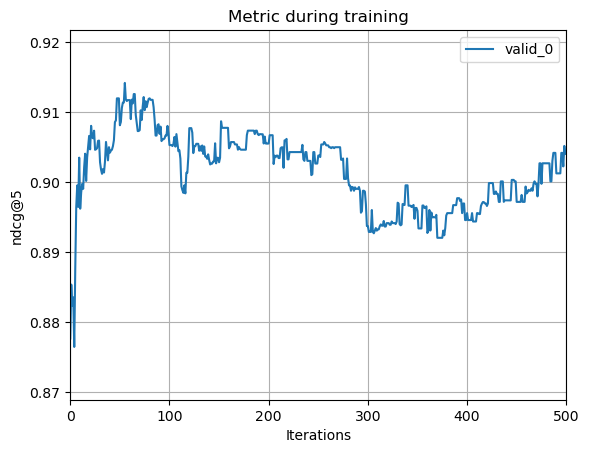

In [84]:
# create ranker model
ranker = lgb.train(params, train_data, num_boost_round=500,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

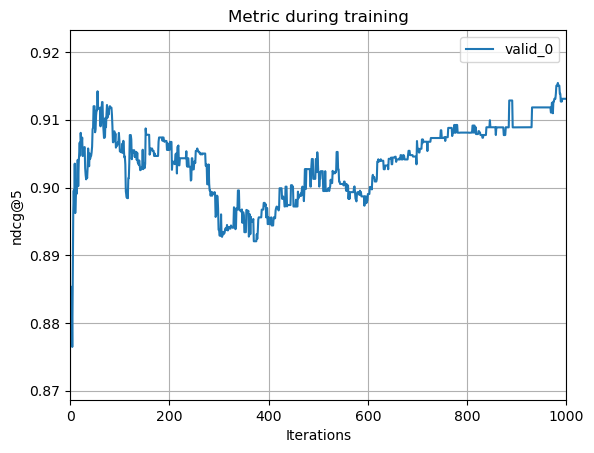

In [85]:
# create ranker model
ranker = lgb.train(params, train_data, num_boost_round=1000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res)

In [ ]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.001,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res = {}
# create ranker model
ranker = lgb.train(params, train_data, num_boost_round=8000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res)

In [ ]:
# Save this model as it is performing well!
#ranker.save_model('ranker_91ndcg')

In [72]:
# I want to be able to get the sum of the feature importance for the features that were one-hot encoded
def get_cumulative_feature_importance(model:lgb.basic.Booster,
    column_names:list)-> pd.DataFrame:
    '''
    Gets the cumulative importance of features.

    Input:
        model: lgb.basic.Booster, the trained model
        column_names: list, a list of names of columns
    '''
    importance_list = model.feature_importance('split')
    column_groups = [x[:x.rindex('_')] if '_' in x else x for x in column_names]
    importance_df = pd.DataFrame([column_groups,column_names,importance_list], index=['Group', 'Feature','Importance']).T
    return(importance_df)

In [76]:
# get the feature importance df
features = get_cumulative_feature_importance(ranker,total_names)
features.head()

,Group,Feature,Importance
0,line,line,35737
1,sentiment,sentiment,100
2,embedding,embedding_0,572
3,embedding,embedding_1,810
4,embedding,embedding_2,594


In [ ]:
# something may be wrong with the sentiment

In [75]:
# group the features that were one-hot encoded
cumulative_features = features.groupby(['Group'])['Importance'].sum().reset_index().sort_values('Importance',ascending=False)
cumulative_features
# cum_ft_imp=cum_ft_imp.head(7)
# cum_ft_imp['Full Name']=['Quotes by Character in Series','Quotes by Character in Episode',
# 'Length of Quote','Sentiment','Length of Next Quote','Sentiment of Previous Quote','Previous Quote Length']

,Group,Importance
1,embedding,547548
4,line,35737
7,scene,17699
10,total_quotes,9505
2,episode,7122
5,location,5308
0,character,1926
9,series,745
6,quote,381
11,view,157
